---
$\Huge{Tabular\ Playground\ Series\ -\ Mar\ 2022}$

$Practice\ your\ ML\ skills\ on\ this\ approachable\ dataset!$

---

# Overview

## Description

For the March edition of the 2022 Tabular Playground Series you're challenged to forecast twelve-hours of traffic flow in a U.S. metropolis. The time series in this dataset are labelled with both location coordinates and a direction of travel -- a combination of features that will test your skill at spatio-temporal forecasting within a highly dynamic traffic network.

Which model will prevail? The venerable linear regression? The deservedly-popular ensemble of decision trees? Or maybe a cutting-edge graph neural-network? We can't wait to see!

### About the Tabular Playground Series

Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, we've launched many Playground competitions that are more approachable than our Featured competitions and thus, more beginner-friendly.

The goal of these competitions is to provide a fun and approachable-for-anyone tabular dataset to model. These competitions are a great choice for people looking for something in between the Titanic Getting Started competition and the Featured competitions. If you're an established competitions master or grandmaster, these probably won't be much of a challenge for you; thus, we encourage you to avoid saturating the leaderboard.

For each monthly competition, we'll be offering Kaggle Merchandise for the top three teams. And finally, because we want these competitions to be more about learning, we're limiting team sizes to 3 individuals.

# Libraries Import
## Regular Libraries

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col=0, parse_dates=['time'])
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col=0, parse_dates=['time'])

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)  
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 11.94 Mb (69.3% reduction)
Mem. usage decreased to  0.03 Mb (68.2% reduction)


In [5]:
from datetime import datetime
from math import sin, cos, pi


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split


import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

import matplotlib.pyplot as plt

In [6]:
# Memorial Day
train = train[(train.time.dt.month != 5) | (train.time.dt.day != 27)]

# July 4
train = train[(train.time.dt.month != 7) | (train.time.dt.day != 4)]

# Labor Day
train = train[(train.time.dt.month != 9) | (train.time.dt.day != 2)]

In [7]:
def fe0(data):
    data['weekday'] = data.time.dt.weekday
    data['hour'] = data.time.dt.hour
    data['timeofday'] = data.time.dt.time

    data['saturday'] = data['weekday'] == 5
    data['sunday'] = data['weekday'] == 6
    data['minute'] = data.time.dt.minute
    data = data.drop(columns='time')
    return data

In [8]:
train = fe0(train)
test = fe0(test)

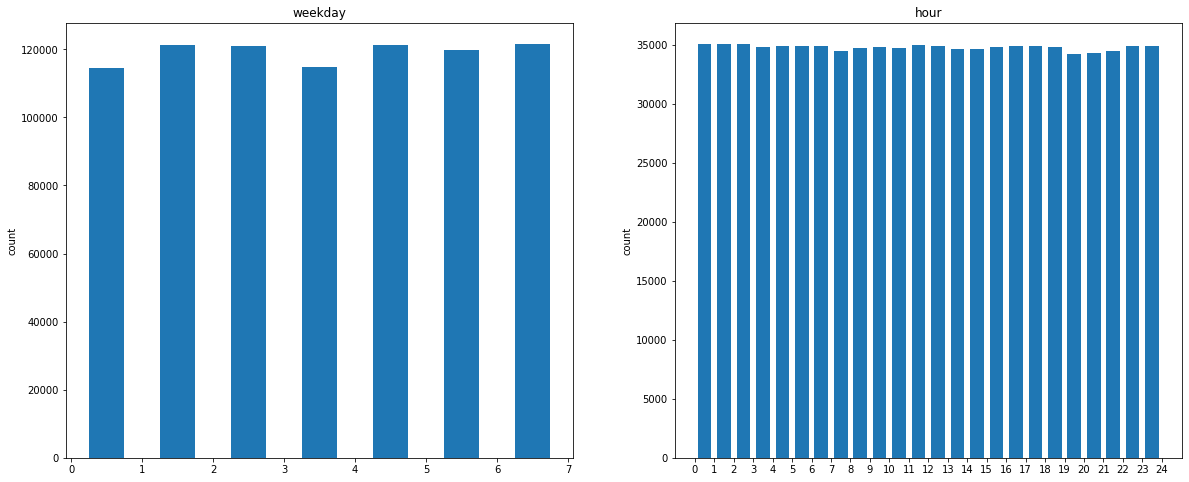

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
bin_weekday = list(range(8))
axs[0].hist(train.weekday, bin_weekday, rwidth=0.5)
axs[0].set_title('weekday')
axs[0].set_xticks(bin_weekday)
axs[0].set_ylabel('count')

bin_hour = list(range(25))
axs[1].hist(train.hour, bin_hour, rwidth=0.7)
axs[1].set_title('hour')
axs[1].set_xticks(bin_hour)
axs[1].set_ylabel('count')

plt.show()

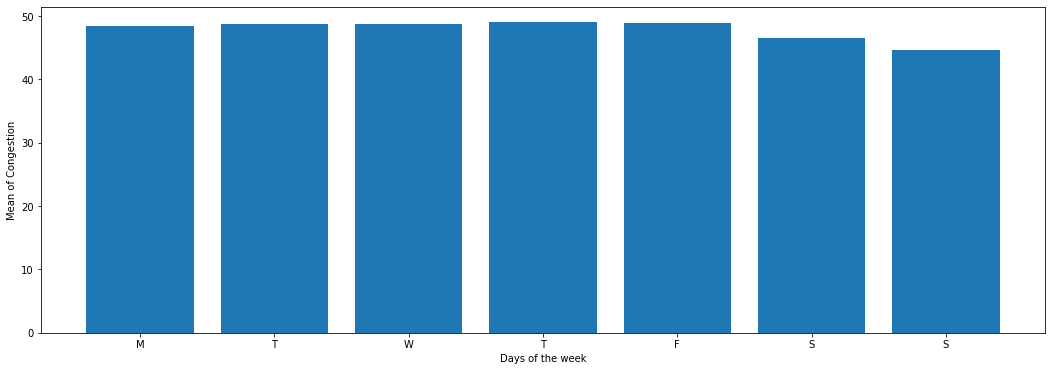

In [10]:
temp = train.groupby(train.weekday).congestion.mean()
plt.figure(figsize=(18, 6))
plt.bar(temp.index, temp)
plt.xticks(ticks=temp.index, labels='MTWTFSS')
plt.xlabel('Days of the week')
plt.ylabel('Mean of Congestion')
plt.show()

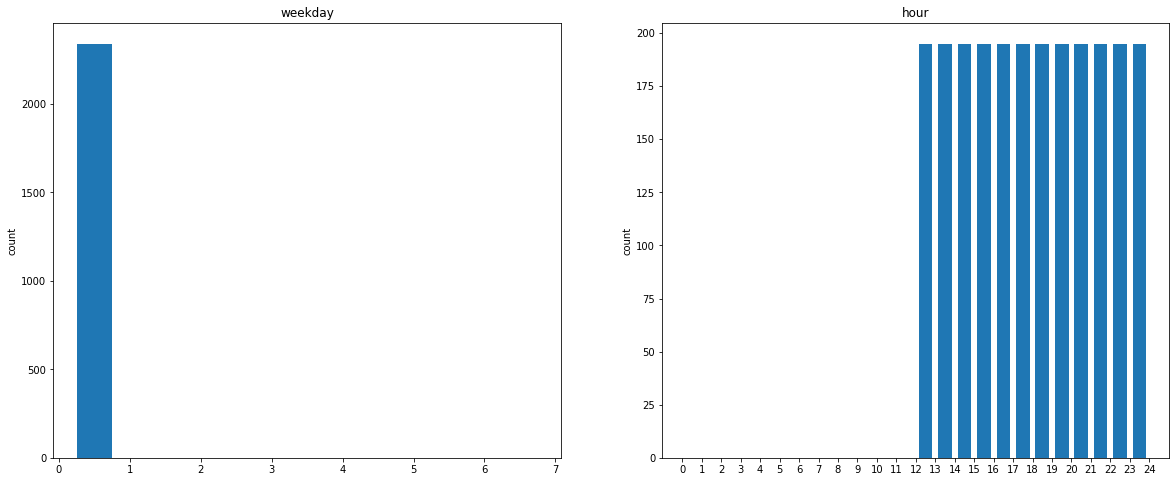

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
bin_weekday = list(range(8))
axs[0].hist(test.weekday, bin_weekday, rwidth=0.5)
axs[0].set_title('weekday')
axs[0].set_xticks(bin_weekday)
axs[0].set_ylabel('count')

bin_hour = list(range(25))
axs[1].hist(test.hour, bin_hour, rwidth=0.7)
axs[1].set_title('hour')
axs[1].set_xticks(bin_hour)
axs[1].set_ylabel('count')

plt.show()

In [12]:
train = train[train.hour >= 12]

In [13]:
target = train.congestion
train = train.drop(columns='congestion')


In [14]:
train.head()

,x,y,direction,weekday,hour,timeofday,saturday,sunday,minute
row_id,,,,,,,,,
2340,0,0,EB,0,12,12:00:00,False,False,0
2341,0,0,NB,0,12,12:00:00,False,False,0
2342,0,0,SB,0,12,12:00:00,False,False,0
2343,0,1,EB,0,12,12:00:00,False,False,0
2344,0,1,NB,0,12,12:00:00,False,False,0


In [15]:
ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(train)

OneHotEncoder(drop='first', sparse=False)

In [16]:
def fe1(data):
    data_ohe = ohe.transform(data)
    df = pd.DataFrame(data_ohe, index=data.index)
    return df

In [17]:
x_data = fe1(train)
x_test = fe1(test)

In [18]:
num_feature = x_data.shape[1]
num_feature

68

In [19]:
x_data = x_data.values
x_test = x_test.values
target = target.values.reshape(-1, 1)

In [20]:
x_data = torch.tensor(x_data)
x_test = torch.tensor(x_test)
target = torch.tensor(target)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [22]:
x_data = x_data.double().to(device)
x_test = x_test.double().to(device)
target = target.double().to(device)

In [23]:
x_train, x_val, y_train, y_val = train_test_split(x_data, target)

In [24]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_feature, 300), 
            nn.ReLU(), 
            nn.Linear(300, 100), 
            nn.ReLU(),
            nn.Linear(100, 50), 
            nn.ReLU(), 
            nn.Linear(50, 1)
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = Net().double().to(device)

In [25]:
def init_weight(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight.data)
model.apply(init_weight)

Net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=68, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.data


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

In [27]:
learning_rate = 1e-3
batch_size = 128
epochs = 1000

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_list_train = []
loss_list_test = []
for t in range(epochs):
    loss_train = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(val_dataloader, model, loss_fn)
    loss_list_train.append(loss_train)
    loss_list_test.append(test_loss)
    if t % 50 == 0:
        print(f'epoch {t} loss {test_loss}')
print("Done!")

epoch 0 loss 11.277157262210206
epoch 50 loss 5.7615489912459985
epoch 100 loss 5.735381135951092
epoch 150 loss 5.717889972468779
epoch 200 loss 5.697944486894786
epoch 250 loss 5.716942624187609
epoch 300 loss 5.728689523754544
epoch 350 loss 5.676677217289932
epoch 400 loss 5.697502370923407
epoch 450 loss 5.681804735508629
epoch 500 loss 5.722778917126354
epoch 550 loss 5.738911133195306
epoch 600 loss 5.752726187183447
epoch 650 loss 5.685690859705295
epoch 700 loss 5.695944336424816
epoch 750 loss 5.698491414325681
epoch 800 loss 5.684842412564704
epoch 850 loss 5.69526306638407
epoch 900 loss 5.705160991614995
epoch 950 loss 5.69242858931522
Done!


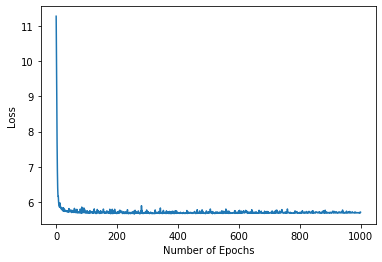

In [28]:
plt.plot(range(epochs),loss_list_test)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.show()

In [29]:
with torch.no_grad():
    y_test = model(x_test)
    y_test = torch.round(y_test)
y_test

tensor([[49.],
        [36.],
        [57.],
        ...,
        [72.],
        [13.],
        [41.]], device='cuda:0', dtype=torch.float64)

In [30]:
sub = pd.read_csv('../input/tabular-playground-series-mar-2022/sample_submission.csv')
sub.congestion = y_test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
